In [1]:
import numpy as np
import matplotlib.pyplot as plt
import scienceplots
import scipy.linalg as LA
from scipy.signal import lsim, dlsim
from scipy.integrate import solve_ivp
import opentorsion as ot
import cvxpy as cp

In [2]:
plt.style.use(['science', 'ieee'])
plt.rcParams["figure.figsize"] = (10,4)

# The propulsion system

Firstly, the propulsion system presented in [Inverse ice-induced moment determination on the propeller of an ice-going vessel](https://www.sciencedirect.com/science/article/pii/S0165232X14002274) is modelled using the openTorsion library. Parameters for the propulsion system are found from [here](https://journals.sagepub.com/doi/full/10.1177/14759217211004232).

In [3]:
def propulsion_system():
    J1 = 1.347e4 # propeller
    J3 = 5.590e2
    J5 = 5.120e2
    J7 = 4.870e2
    J9 = 1.410e2
    J11 = 1.740e2
    J13 = 4.415e3 # motor
    
    k2 = 5.88e7
    k4 = 5.95e7
    k6 = 1.12e8
    k8 = 6.93e8
    k10 = 5.09e8
    k12 = 1.43e8
    damping = 180 # damping in steel_shafts
    
    shafts, disks = [], []
    disks.append(ot.Disk(0, I=J1))
    shafts.append(ot.Shaft(0, 1, None, None, k=k2, I=0, c=damping))
    disks.append(ot.Disk(1, I=J3))
    shafts.append(ot.Shaft(1, 2, None, None, k=k4, I=0, c=damping))
    disks.append(ot.Disk(2, I=J5))
    shafts.append(ot.Shaft(2, 3, None, None, k=k6, I=0, c=damping))
    disks.append(ot.Disk(3, I=J7))
    shafts.append(ot.Shaft(3, 4, None, None, k=k8, I=0, c=damping))
    disks.append(ot.Disk(4, I=J9))
    shafts.append(ot.Shaft(4, 5, None, None, k=k10, I=0, c=damping))
    disks.append(ot.Disk(5, I=J11))
    shafts.append(ot.Shaft(5, 6, None, None, k=k12, I=0, c=damping))
    disks.append(ot.Disk(6, I=J13))
    
    assembly = ot.Assembly(shafts, disk_elements=disks)
    _, f, _ = assembly.modal_analysis()
    print("Eigenfrequencies: ", f.round(2))

    return assembly

In [4]:
def state_matrices(assembly):
    """
    Create state-space matrices A and B of an openTorsion assembly.

    Parameters:
    assembly : openTorsion assembly instance
        Mechanical drivetrain model.

    Returns:
    A : numpy.ndarray
        The state matrix
    B : numpy.ndarray
        The input matrix
    """
    M, C, K = assembly.M, assembly.C, assembly.K  # Mass and stiffness matrices
    Z = np.zeros(M.shape)
    I = np.eye(M.shape[0])
    M_inv = LA.inv(M)

    A = np.vstack([np.hstack([Z, I]), np.hstack([-M_inv @ K, -M_inv @ C])])

    B = np.vstack([Z, M_inv])

    return A, B

In [5]:
def c2d(A,B,Ts):
    """
    C2D computes a discrete-time model of a system (A_c,B_c) with sample time T_s.
    The function returns matrices A,B of the discrete-time system.
    """
    m, n = A.shape
    nb = B.shape[1]

    s = np.concatenate([A, B], axis=1)
    s = np.concatenate([s, np.zeros( (nb,n+nb) )], axis=0)
    S = LA.expm(s*Ts)
    Ad = S[0:n,0:n]
    Bd = S[0:n,n:n+nb+1]
    
    return Ad, Bd

In [6]:
def X(k_values, ndof):
    """
    Used to transform the state-matrix to be compatible with shaft torque as a state.
    """
    rows = ndof-1
    cols = ndof
    if len(k_values) != rows:
        print("wrong amount of stiffness values / dofs")
        return
    
    X_up = np.zeros((rows, cols))
    X_down = np.eye(cols)
    Z_up = np.zeros(X_up.shape)
    Z_down = np.zeros(X_down.shape)
    
    for i in range(rows):
        X_up[i,i] = -k_values[i]
        X_up[i,i+1] = k_values[i]
    
    X_matrix = np.vstack([np.hstack([X_up, Z_up]), np.hstack([Z_down, X_down])])
    
    return X_matrix

The model is defined to have shaft torques and nodal rotational speeds as states. The state-space model is as follows (details in the "modified_state_matrix_2dof" notebook):

$$ \begin{bmatrix} \dot{\tau}_{1,2} \\ \vdots \\ \dot{\tau}_{n-1,n} \\ \ddot{\theta}_1 \\ \vdots \\  \ddot{\theta}_n \end{bmatrix}_{2n-1 \times 1} = \textbf{X}_{2n-1 \times 2n} \textbf{A}_{2n \times 2n} \textbf{X}^{-1}_{2n \times 2n-1} \begin{bmatrix} \tau_{1,2} \\ \vdots \\ \tau_{n-1,n} \\ \dot{\theta}_1 \\ \vdots \\ \dot{\theta}_n \end{bmatrix}_{2n-1 \times 1} + \textbf{X}_{2n-1 \times 2n} \textbf{B}_{2n-1 \times n} \begin{bmatrix} T \\ \vdots \\ 0 \end{bmatrix}_{n \times 1} $$

where $n$ is the number of degrees of freedom of the system, $\textbf{A}$ and $\textbf{B}$ are the state matrices and $T$ is load torque (in this case applied on node 0).

### Construction of the extended observability matrix and the impulse response matrix used in the data equation.

In [7]:
def O(A, C, n):
    '''
    Create the extended observability matrix used in the data equation.

    Parameters:

    A : numpy.ndarray
        The state matrix of the state-space system
    C : numpy.ndarray
        The observation matrix of the state-space system
    n : float
        number of measurements

    Returns:

    O : numpy.ndarray, shape(n, number of state variables)
        The extended observability matrix
    '''
    A_power = np.copy(A)
    O = np.vstack((np.copy(C), C @ A))
    
    for k in range(n-2):
        A_power = A_power @ A
        O = np.vstack((O, C @ A_power))

    return O

In [8]:
def gamma(A, B, C, n):
    '''
    Create the impulse response matrix used in the data equation.

    Parameters:

    A : numpy.ndarray
        The state matrix of the state-space system
    B : numpy.ndarray
        The input matrix of the state-space system
    C : numpy.ndarray
        The observation matrix of the state-space system
    n : float
        number of measurements

    Returns:

    gamma : numpy.ndarray, shape(n*number of state variables, n*number of state variables)
        The impulse response matrix
    '''
    A_power = np.copy(A)
    Z = np.zeros((C @ B).shape)
    
    # first column
    gamma_column_first = np.vstack((
        Z,
        C @ B, 
        C @ A @ B
    ))
    for _ in range(n-3):
        A_power = A_power @ A
        gamma_column_first = np.vstack((gamma_column_first, C @ A_power @ B))

    # build complete matrix, column by column, from left to right
    gamma = np.copy(gamma_column_first)
    current_column = 1
    for _ in range(1, n):
        gamma_rows = Z
        
        # first add zero matrices
        for _ in range(current_column):
            gamma_rows = np.vstack((gamma_rows, Z))
        
        # then add the impulse responses
        A_power2 = np.copy(A)
        
        if current_column < (n-2):
            gamma_rows = np.vstack((
                gamma_rows,
                C @ B,
                C @ A @ B # these must not be added to the last and the second to last columns
            ))
            
        if current_column == (n-2):
            gamma_rows = np.vstack((
                gamma_rows,
                C @ B # this has to be added to the end of the second to last column
            ))
        
        for _ in range(n-current_column-3):
            A_power2 = A_power2 @ A
            gamma_rows = np.vstack((gamma_rows, C @ A_power2 @ B))

        # add column on the right hand side
        gamma = np.hstack((gamma, gamma_rows))
        current_column += 1
    
    return gamma

### The regularization matrix

The regularization matrix $L$ as presented in the paper of Ikonen et al. (Note: In the paper, the external load of the propulsion system model is described in changes of moment between consecutive timesteps. Perhaps an identity matrix should be used here?)

In [9]:
def L(input_shape):
    '''
    The regularization matrix L.

    Parameters:

    input_shape : float
        Input vector shape used to determine L matrix shape.

    Returns:

    L : ndarray
        The regularization matrix
    '''
    I = np.eye(input_shape)
    L = -I + np.diag(np.ones(input_shape-1), 1)

    return I

In [10]:
def second_difference_matrix(n, m):
    D2 = np.eye(n*m) - 2*np.eye(n*m, k=2) + np.eye(n*m, k=4)

    # delete incomplete rows
    D2 = D2[:-2*m, :]

    return D2

In [11]:
def dft_matrix(N):
    n = np.arange(N)
    k = n.reshape((N, 1))
    W = np.exp(-2j * np.pi * k * n / N)

    return W / np.sqrt(N)

In [12]:
def DFT_matrix(N):
    i, j = np.meshgrid(np.arange(N), np.arange(N))
    omega = np.exp(-2 * np.pi * 1j / N)
    W = np.power(omega, i * j) / np.sqrt(N)

    return W

### Convex optimization problem

Here a Tikhonov-regularized optimization problem is defined using measurements from the propulsion system model, the data equation matrix $\Gamma$ and the regularization matrix $L$. For the present case, an optimal regularization parameter $\lambda = 0.0512$ is defined using the L-curve plot in the paper of Ikonen et al.

The python package [CVXPY](https://www.cvxpy.org/) provides an interface for the solver ([SCS](https://www.cvxgrp.org/scs/) or [MOSEK](https://www.mosek.com/)), which is used to solve the Tikhonov-regularized optimization problem.

In [13]:
def convex_optimization_problem(meas, obsrv, gamm, regu, initial_state=None, lam=0.0512):
    '''
    Convex optimization methods using the cvxpy library.
    '''
    d = cp.Variable((gamm.shape[1], 1))
    
    if initial_state is None:
        x = np.zeros((obsrv.shape[1], 1))
    else:
        x = initial_state
        
    measurements = cp.Parameter(meas.shape)
    measurements.value = meas
    
    objective = cp.Minimize(cp.sum_squares(measurements - obsrv @ x - gamm @ d) + lam * cp.sum_squares(regu @ d))
    prob = cp.Problem(objective)
    
    prob.solve()

    return d.value

In [14]:
def lasso_problem(meas, obsrv, gamm, regu, initial_state=None, lam=1, use_sparse=False, cmplx=False):
    '''
    This function uses the cvxpy library to solve a LASSO problem.
    '''
    d = cp.Variable((gamm.shape[1], 1), complex=cmplx)

    if initial_state is None:
        x = cp.Variable((obsrv.shape[1], 1), complex=cmplx)
    else:
        x = initial_state

    #measurements = cp.Parameter(meas.shape)
    #measurements.value = meas
    measurements = meas

    if use_sparse:
        objective = cp.Minimize(cp.sum_squares(measurements - gamm @ regu @ d) + lam * cp.pnorm(d, 1))
    else:        
        objective = cp.Minimize(cp.sum_squares(measurements - obsrv @ x - gamm @ d) + lam * cp.pnorm(regu @ d, 1))

    prob = cp.Problem(objective)
    prob.solve()

    if initial_state is None:
        x_value = x.value
    else:
        x_value = initial_state

    return d.value

### Unit step response of the propulsion system

Here a unit step response is calculated for the propulsion system. The shaft torque between nodes 3 and 4 is plotted, as is in the paper of Ikonen et al.

In [15]:
# Initialize an assembly instance and construct the state-space model
assembly = propulsion_system()
ndof = assembly.dofs
A, B = state_matrices(assembly)
C = np.eye(B.shape[0])
D = np.zeros(B.shape)

# The state-space model is modified to have shaft torque as a state (instead of nodal angles).
k_list = [5.88e7, 5.95e7, 1.12e8, 6.93e8, 5.09e8, 1.43e8]
trans = X(k_list, ndof)
trans_inv = trans.T @ np.linalg.inv(trans @ trans.T)
A_transformed = trans @ A @ trans_inv
B_transformed = trans @ B
C_transformed = np.eye(B_transformed.shape[0])
D_transformed = np.zeros(B_transformed.shape)
A_transformed = A_transformed.astype('d')
B_transformed = B_transformed.astype('d')
C_transformed = C_transformed.astype('d')
D_transformed = D_transformed.astype('d')

Eigenfrequencies:  [    0.      -0.      71.68   -71.68   307.46  -307.46   495.22  -495.22
   724.26  -724.26  1687.71 -1687.71  3284.88 -3284.88]


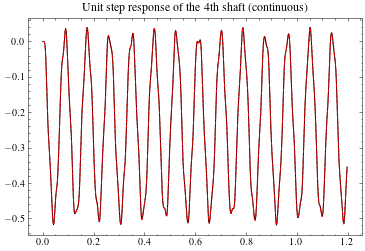

In [16]:
# In Ikonen et al., the simulation is defined to be 1.2 seconds with a step of 2 ms.
t = np.arange(0, 1.200, 0.002)

# Impulse load applied at node 0.
u = np.zeros((len(t), 7))
u[:,0] = 1

tout, yout, xout = lsim((A, B, C, D), u, t)
tout_mod, yout_mod, xout_mod = lsim((A_transformed, B_transformed, C_transformed, D_transformed), u, t)

plt.plot(tout, 6.93e8*(yout[:,4] - yout[:,3]))
plt.plot(tout_mod, yout_mod[:,3], '--')
plt.title("Unit step response of the 4th shaft (continuous)")
plt.show()

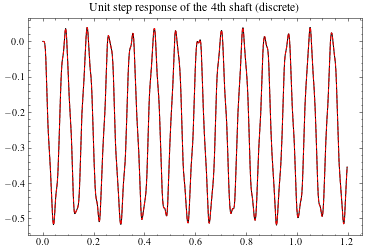

In [17]:
# discrete-time model
dt = np.mean(np.diff(t))

A_d, B_d = c2d(A, B, dt)
dtout, dyout, dxout = dlsim((A_d, B_d, C, D, dt), u, t=t)

A_transformed_d, B_transformed_d = c2d(A_transformed, B_transformed, dt)
dtout_mod, dyout_mod, dxout_mod = dlsim((A_transformed_d, B_transformed_d, C_transformed, D_transformed, dt), u, t=t)

plt.plot(dtout, 6.93e8*(dyout[:,4] - dyout[:,3]))
plt.plot(dtout_mod, dyout_mod[:,3], '--')
plt.title("Unit step response of the 4th shaft (discrete)")
plt.show()

### Verify $\mathcal{O}$ and $\Gamma$ matrices

In [18]:
N = len(t)
B_t_d = np.array(B_transformed_d[:,0]).reshape(B_transformed_d.shape[0],1)

extended_observation = O(A_transformed_d, C_transformed, N)
impulse_response = gamma(A_transformed_d, B_t_d, C_transformed, N)

x0 = np.zeros((extended_observation.shape[1], 1))

# Impulse load applied at node 0.
U = np.ones((len(t), 1))

y_hat = extended_observation @ x0 + impulse_response @ U
meases = np.hstack(np.vsplit(y_hat, N))

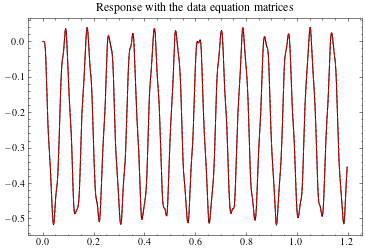

In [19]:
plt.plot(t, meases[3,:])
plt.plot(dtout_mod, dyout_mod[:,3])
plt.title('Response with the data equation matrices')
plt.show()

### Generating measurement data

To avoid inverse crime, in the paper of Ikonen et al., the propulsion system model defined above is modified by varying the inertia and stiffness values by $\pm 10$%. An additional damping coefficient for the propeller is also defined.

In [20]:
def propulsion_system_rand():
    J1 = np.random.uniform(0.9, 1.1)*1.347e4 # propeller
    J3 = np.random.uniform(0.9, 1.1)*5.590e2
    J5 = np.random.uniform(0.9, 1.1)*5.120e2
    J7 = np.random.uniform(0.9, 1.1)*4.870e2
    J9 = np.random.uniform(0.9, 1.1)*1.410e2
    J11 = np.random.uniform(0.9, 1.1)*1.740e2
    J13 = np.random.uniform(0.9, 1.1)*4.415e3 # motor
    
    k2 = np.random.uniform(0.9, 1.1)*5.88e7
    k4 = np.random.uniform(0.9, 1.1)*5.95e7
    k6 = np.random.uniform(0.9, 1.1)*1.12e8
    k8 = np.random.uniform(0.9, 1.1)*6.93e8
    k10 = np.random.uniform(0.9, 1.1)*5.09e8
    k12 = np.random.uniform(0.9, 1.1)*1.43e8
    
    damping = 180 # damping in steel_shafts
    propeller_damping = 120e3 # the propeller damping
    
    shafts, disks = [], []
    disks.append(ot.Disk(0, I=J1))
    shafts.append(ot.Shaft(0, 1, None, None, k=k2, I=0, c=propeller_damping+damping))
    disks.append(ot.Disk(1, I=J3))
    shafts.append(ot.Shaft(1, 2, None, None, k=k4, I=0, c=damping))
    disks.append(ot.Disk(2, I=J5))
    shafts.append(ot.Shaft(2, 3, None, None, k=k6, I=0, c=damping))
    disks.append(ot.Disk(3, I=J7))
    shafts.append(ot.Shaft(3, 4, None, None, k=k8, I=0, c=damping))
    disks.append(ot.Disk(4, I=J9))
    shafts.append(ot.Shaft(4, 5, None, None, k=k10, I=0, c=damping))
    disks.append(ot.Disk(5, I=J11))
    shafts.append(ot.Shaft(5, 6, None, None, k=k12, I=0, c=damping))
    disks.append(ot.Disk(6, I=J13))
    
    assembly = ot.Assembly(shafts, disk_elements=disks)
    _, f, _ = assembly.modal_analysis()
    print("Eigenfrequencies: ", f.round(2))

    return assembly, [k2, k4, k6, k8, k10, k12]

In [21]:
# Here the assembly is initialized again, as the component parameters are randomized.
# The system matrices are also constructed again.
assembly_rand, k_list_rand = propulsion_system_rand()
A_rand, B_rand = state_matrices(assembly_rand)
C_rand, D_rand = np.eye(B_rand.shape[0]), np.zeros(B_rand.shape)

trans_rand = X(k_list_rand, ndof)
trans_inv_rand = trans_rand.T @ np.linalg.inv(trans_rand @ trans_rand.T)
A_mod_rand = trans_rand @ A_rand @ trans_inv_rand
B_mod_rand = trans_rand @ B_rand
C_mod_rand = np.eye(B_mod_rand.shape[0])
D_mod_rand = np.zeros(B_mod_rand.shape)

Eigenfrequencies:  [    0.      -0.      73.13   -73.13   325.21  -325.21   481.43  -481.43
   747.1   -747.1   1735.57 -1735.57  3462.89 -3462.89]


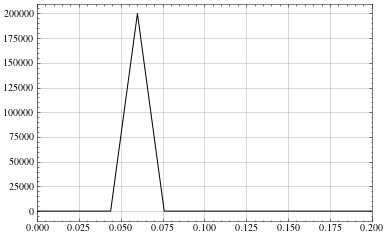

In [22]:
# An impulse load similar to the one described in Ikonen et al.
t = np.arange(0, 1.200, 0.002)

# impulse applied at node 0
impulse = np.zeros((len(t), 7))
ramp = np.arange(0, 200000, int(200000/8))
impulse[22:30,0] = ramp
impulse[30,0] = 200000
impulse[31:39,0] = ramp[::-1]

plt.plot(t, impulse[:,0])
plt.xlim(0,0.2)
plt.grid()
plt.show()

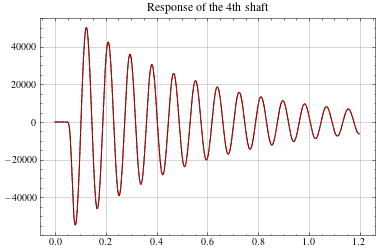

In [23]:
tout_rand, yout_rand, xout_rand = lsim((A_rand, B_rand, C_rand, D_rand), impulse, t)

tout_modded, yout_modded, xout_modded = lsim((A_mod_rand, B_mod_rand, C_mod_rand, D_mod_rand), impulse, t)

torque_meas_rand = k_list_rand[3]*(yout_rand[:,4]-yout_rand[:,3])

yout_modded_rand = np.random.uniform(0.99, 1.01)*yout_modded # Randomization of +-1% is added to the measurement.

plt.plot(tout_rand, torque_meas_rand)
plt.plot(tout_modded, yout_modded_rand[:,3], '--')
plt.grid()
plt.title("Response of the 4th shaft")
plt.show()

The convex optimization problem is solved using batches of measurements of $n$ consecutive timesteps.

In [24]:
n = len(t) # number of measurements in the batch
estimates = np.zeros((n,1))

C_d = np.array([0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0]) # measurement is torque of shaft 4

observer = O(A_transformed_d, C_d, n)
gam = gamma(A_transformed_d, B_t_d, C_d, n)

reg = L(n)

In [25]:
Y = yout_modded_rand[:,3].reshape(n,1)

estimate = convex_optimization_problem(Y, observer, gam, reg, lam=0.00001)

In [26]:
estimate_l1 = lasso_problem(Y, observer, gam, reg, initial_state=np.zeros((observer.shape[1], 1)), lam=0.1)

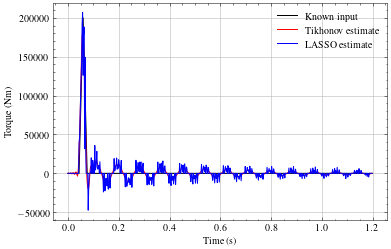

In [27]:
%matplotlib inline
plt.plot(t, impulse[:,0], label='Known input', linestyle='solid')
plt.plot(t, estimate, label='Tikhonov estimate', linestyle='solid')
plt.plot(t, estimate_l1, label='LASSO estimate', linestyle='solid')
plt.legend()
plt.xlabel('Time (s)')
plt.ylabel('Torque (Nm)')
plt.grid()
plt.show()

In [28]:
print(np.where(estimate==max(estimate)))

(array([29]), array([0]))


# RTSKF

In [29]:
def robust_2stage_KF(m0, P0, y, N, A, E, H, Q, R):
    x = np.zeros((N,13))
    P = np.zeros((N,13,13))
    d = np.zeros(N)
    I = np.eye(13)
    
    x[0], P[0] = m0, P0
    
    for i in range(1, N):
        # State estimate prediction
        x_ = A @ x[i-1]
        P_ = A @ P[i-1] @ A.T + Q
        C_inv = LA.inv(H @ P_ @ H.T + R)
        v = y[i] - H @ x_
        
        # Input estimate update
        P_d = LA.inv(E.T @ H.T @ C_inv @ H @ E)
        K_d = P_d @ E.T @ H.T @ C_inv
        d[i] = K_d @ v
        
        # State estimate update
        K = P_ @ H.T @ C_inv
        V = (I - K @ H) @ E
        P_k = (I - K @ H) @ P_
        x_k = x_ + K @ v
        
        x[i] = x_k + (V * d[i]).ravel()
        P[i] = P_k + V @ P_d @ V.T
    
    return d, x, P

In [30]:
def robust_recursive_KF(m0, P0, y, N, A1, G, C, Q, R):
    x = np.zeros((N,13))
    P = np.zeros((N,13,13))
    d = np.zeros(N)
    I = np.eye(13)
    F = C @ G
    
    x[0], P[0] = m0, P0
    
    for i in range(1, N):
        # State estimate prediction
        x_ = A1 @ x[i-1]
        P_ = A1 @ P[i-1] @ A1.T + Q
        
        print(i)
        print(P_)
        R_k_inv = LA.inv(C @ P_ @ C.T + R)
        
        # Input estimate update
        M_k = LA.inv(F.T @ R_k_inv @ F) @ F.T @ R_k_inv
        d[i-1] = M_k @ (y[i] - C @ x_)
        
        # State estimate update
        K_k = P_ @ C.T @ R_k_inv
        x_k = x_ + (G * d[i-1]).ravel()
        x[i] = x_k + K_k @ (y[i] - C @ x_k)
        # Estimate covariance update
        P_k = (I - G @ M_k @ C) @ P_ @ (I - G @ M_k @ C).T + G @ M_k @ R @ M_k.T @ G.T
        S_k = -G @ M_k @ R
        P[i] = P_k - K_k @ (P_k @ C.T + S_k).T
    
    d[-1] = d[-2]
        
    return d, x, P

In [31]:
Q = np.diag(np.ones(13))*0.1
R = np.diag(np.ones(13))*0.1
m0 = np.ones(13)
P0 = np.diag(np.ones(13))*0.1

measurements_rtskf = np.vstack([
    yout_modded_rand[:,3],
    yout_modded_rand[:,4],
    yout_modded_rand[:,7]
]).T

#Cd = np.zeros((3,13))
#Cd[0,3] += 1
#Cd[1,4] += 1
#Cd[2,7] += 1
Cd = np.eye(13)

rtskf_input, rtskf_states, rtskf_covariance = robust_2stage_KF(
    m0,
    P0,
    yout_modded_rand,
    #measurements_rtskf,
    600,
    A_transformed_d,
    B_t_d,
    Cd,
    Q,
    R
)

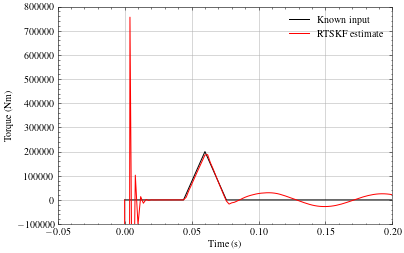

In [32]:
plt.plot(t, impulse[:,0], label='Known input', linestyle='solid')
plt.plot(t, rtskf_input, label='RTSKF estimate', linestyle='solid')
plt.legend()
plt.xlabel('Time (s)')
plt.ylabel('Torque (Nm)')
plt.xlim(-0.05, 0.2)
plt.ylim(-100000, 800000)
plt.grid()
plt.show()

# Conjugate gradient method

In [33]:
def CG(y, W, tol, max_iters=5000):
    converged = False
    # Normal equations
    WtW = W.T @ W
    y = W.T @ y
    
    # init
    x_k = np.zeros((WtW.shape[0],1))
    r_k = y - WtW @ x_k
    if np.linalg.norm(r_k) < tol: converged = True
    p_k = r_k
    k = 0
    residuals = []
    
    # Conjugate gradient loop
    while not converged:
        a_k = (r_k.T @ r_k) / (p_k.T @ WtW @ p_k)
        x_k += a_k * p_k
        r_k_new = r_k - a_k * WtW @ p_k
        if np.linalg.norm(r_k_new) < tol: converged = True
        b_k = (r_k_new.T @ r_k_new) / (r_k.T @ r_k)
        p_k = r_k_new + b_k * p_k
        r_k = r_k_new
        residuals.append(np.linalg.norm(r_k))
        k += 1
        if k > max_iters: converged = True
        
    print("Number of iterations: ", k)
    return x_k, residuals

Number of iterations:  836


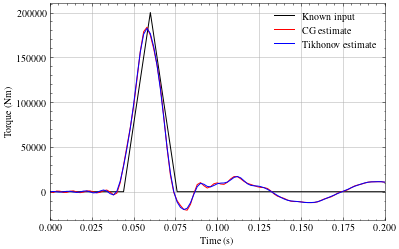

In [34]:
tolerance = 0.1# * np.sqrt(600)
cg_estimates, residuals = CG(Y, gam, tolerance)

plt.clf()
plt.plot(t, impulse[:,0], label='Known input', linestyle='solid')
plt.plot(t, cg_estimates, label='CG estimate', linestyle='solid')
plt.plot(t, estimate, label='Tikhonov estimate', linestyle='solid')
plt.legend()
plt.xlabel('Time (s)')
plt.ylabel('Torque (Nm)')
plt.xlim(0,0.2)
plt.grid()
plt.show()

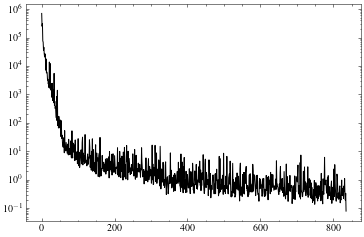

In [35]:
plt.semilogy(residuals)

Number of iterations:  5001


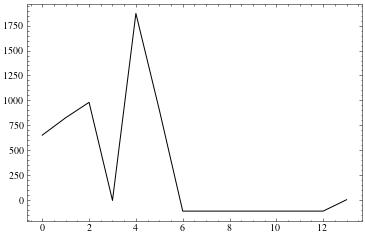

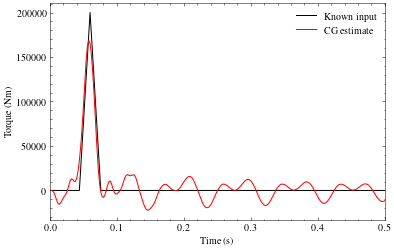

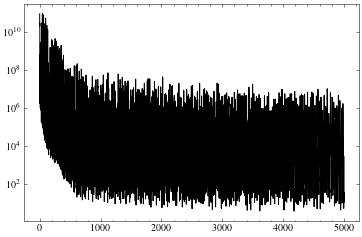

In [36]:
H = np.hstack([observer, gam])

from scipy.linalg import svd

trunk = 300
dynamics = H #gam

u, s, vh = svd(dynamics)
e = 0
if int(vh.shape[0]-u.shape[0]) != 0:
    e = int(vh.shape[0]-u.shape[0])
    vh = vh[:-e, :]
s[int(trunk):] *= 0
dyn = u @ np.diag(s) @ vh

cg_estimates, residuals = CG(Y, dyn, tolerance, max_iters=5000)

plt.clf()
plt.plot(cg_estimates[:14])
plt.show()
plt.clf()
plt.plot(t, impulse[:,0], label='Known input', linestyle='solid')
plt.plot(t, cg_estimates[e:], label='CG estimate', linestyle='solid')
plt.legend()
plt.xlabel('Time (s)')
plt.ylabel('Torque (Nm)')
plt.xlim(0,0.5)
plt.show()
plt.semilogy(residuals)

# Sparse frequency domain estimation

In [56]:
def sinusoidal_excitation(sim_times, plot=False):
    """
    Parameters:
    
    sim_times : numpy.ndarray
        Timesteps of the simulation.
        
    Returns:
    
    U_sin : numpy.ndarray
        Input torque matrix. Rows correspond to timesteps, first column has the motor torque,
        second column has the propeller torque.
    """

    def sum_sines(freqs, amps, phases, times, dc_offset):
        """
        Generates a sinusoidal signal that is a sum of three sine waves with different frequencies.

        Args:
        freqs (list[float]): List of three frequencies for the sine waves.
        amps (list[float]): List of three amplitudes for the sine waves.
        phases (list[float]): List of three phase shifts for the sine waves.
        times (numpy.ndarray): Timesteps of the signal in seconds.

        Returns:
        numpy.ndarray: Sinusoidal signal that is a sum of three sine waves.
        """

        signal = np.zeros(len(times))
        for f, a, p in zip(freqs, amps, phases):
            signal += a * np.sin(2 * np.pi * f * times + p)

        return signal + dc_offset

    freqs = [300/60, 4*300/60, 8*300/60]
    #freqs = [30, 2*30, 3*30]
    amps = [10, 5, 1]
    phases = [0, 0, 0]
    offset = 10
    sine_signal = sum_sines(freqs, amps, phases, sim_times, offset)

    U_sin = np.zeros((len(sim_times), 7))

    e2 = np.random.normal(0, 2, U_sin.shape[0])

    U_sin[:,0] += sine_signal + e2

    if plot:
        plt.plot(sim_times, U_sin[:,0], label='Loading motor setpoint', color='blue')
        plt.xlabel('Time (s)')
        plt.ylabel('Torque (Nm)')
        plt.legend()
        plt.tight_layout()

        plt.show()

    return U_sin

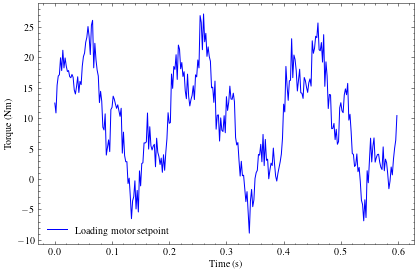

In [57]:
t = np.arange(0, 0.600, 0.002)
n = len(t)
periodic = sinusoidal_excitation(t, plot=True)

#periodic = np.zeros((len(t), 7))
#periodic[:,0] += 2 * np.sin(2 * np.pi * 30 * t) + 4
#plt.plot(t, periodic)

In [58]:
tout_modded2, yout_modded2, xout_modded2 = lsim((A_mod_rand, B_mod_rand, C_mod_rand, D_mod_rand), periodic, t)
yout_modded_rand2 = np.random.uniform(0.99, 1.01)*yout_modded2 # Randomization of +-1% is added to the measurement.
Y2 = yout_modded_rand2[:,3].reshape(n,1)
#Y2 = yout_modded[:,3].reshape(n,1)

In [59]:
reg2 = dft_matrix(len(t))

reg2_other = DFT_matrix(len(t))

print(np.allclose(reg2, reg2_other))

True


In [60]:
reg2_simple = np.exp(np.outer(1j*t*300/60*2*np.pi,np.array([0,1,4,8,-1,-4,-8])))
#reg2_simple = np.exp(np.outer(1j*t*300/60*2*np.pi,np.hstack([np.linspace(1,300,300), -np.linspace(1,300,300)])))
print(reg2_simple.shape)

(300, 7)


/u/60/hakoneu1/unix/.local/lib/python3.8/site-packages/numpy/core/_asarray.py:102: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


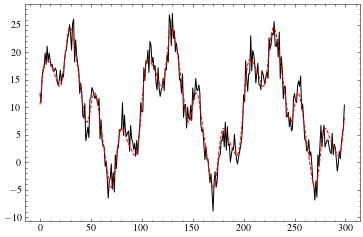

In [61]:
u = np.linalg.inv(reg2_simple.T @ reg2_simple) @ reg2_simple.T @ periodic[:,0]
est = reg2_simple @ u
plt.plot(periodic[:,0])
plt.plot(est)

In [62]:
#u2 = np.linalg.inv(gam.T @ gam + reg2_simple.T @ reg2_simple) @ gam.T @ Y2
#print(u2.shape)
#print(reg2_simple.shape)
#est2 = reg2_simple @ u2
#print(est2.shape)
#plt.plot(periodic[:,0])
#plt.plot(abs(est2))

In [63]:
observer = O(A_transformed_d, C_d, n)
gam = gamma(A_transformed_d, B_t_d, C_d, n)

In [64]:
iso_U = lasso_problem(
    Y2, 
    observer, 
    gam, 
    reg2, 
    initial_state=np.zeros((observer.shape[1], 1)), 
    lam=0.01,
    use_sparse=True,
    cmplx=True
)

(0.0, 300.0)

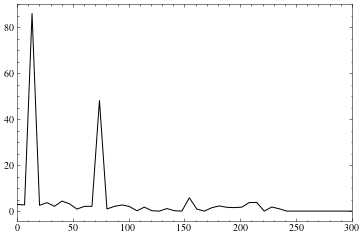

In [65]:
plt.plot(np.linspace(0, 2000, len(t)-1), abs(iso_U[1:]))
plt.xlim(0,300)

In [66]:
sparse_sin_est = reg2 @ iso_U

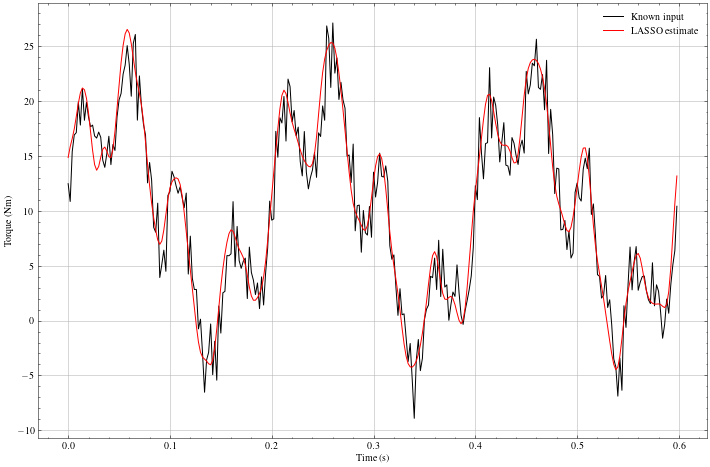

In [69]:
plt.figure(figsize=(12,8))
plt.plot(t, periodic[:,0], label='Known input', linestyle='solid')
plt.plot(t, sparse_sin_est, label='LASSO estimate', linestyle='solid')
plt.legend()
plt.xlabel('Time (s)')
plt.ylabel('Torque (Nm)')
plt.grid()
plt.show()